## Demo 1: Wasserstein distance estimation on toy example

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deel-ai/deel-lip/blob/master/docs/notebooks/demo1.ipynb)

In this notebook we will see how to estimate the wasserstein distance with a Neural net
by using the Kantorovich-Rubinestein dual representation.

### Wasserstein distance

The wasserstein distance measure the distance between two probability distribution.
Wikipedia article gives a more intuitive definition of it:

> Intuitively, if each distribution is viewed as a unit amount of "dirt" piled on M, the
> metric is the minimum "cost" of turning one pile into the other, which is assumed to
> be the amount of dirt that needs to be moved times the mean distance it has to be
> moved. Because of this analogy, the metric is known in computer science as the earth
> mover's distance.

Mathematically it is defined as:

$$
W_1(\mu,\nu) = \inf_{\pi \in \Pi(\mu,\nu)}\underset{x,z \sim \pi}{\mathbb{E}}\parallel \textbf{x}-\textbf{z} \parallel
$$

where $\Pi(\mu,\nu)$ is the set of all probability measures on $\Omega\times \Omega$
with marginals $\mu$ and $\nu$. In most case this equation is not tractable.

### KR dual formulation

In our setup, the KR dual formulation is stated as following: $$ W*1(\mu, \nu) = \sup*{f
\in Lip_1(\Omega)} \underset{\textbf{x} \sim \mu}{\mathbb{E}} \left[f(\textbf{x}
)\right] -\underset{\textbf{x} \sim \nu}{\mathbb{E}} \left[f(\textbf{x} )\right] $$

This state the problem as an optimization problem over the 1-lipschitz functions.
Therefore k-Lipschitz networks allows us to solve this maximization problem.

[1] C. Anil, J. Lucas, et R. Grosse, « Sorting out Lipschitz function approximation »,
arXiv:1811.05381 [cs, stat], nov. 2018.

We will illustrate this on a synthetic image dataset where $W_1$ is known.


In [1]:
# pip install git+https://github.com/deel-ai/deel-lip.git@keras3 -qqq

In [2]:
import numpy as np
import math

import matplotlib.pyplot as plt

import keras
from keras.layers import Input, Flatten, ReLU
from keras.optimizers import Adam
from keras.models import load_model

from deel.lip.layers import SpectralDense, FrobeniusDense
from deel.lip.activations import FullSort
from deel.lip.losses import KR, HKR
from deel.lip.model import Model

2024-09-06 15:02:24.948218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 15:02:24.959398: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 15:02:24.962773: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 15:02:24.971253: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-06 15:02:26.305343: W tensorflow/compiler/tf2

### Parameters input images

The synthetic dataset will be composed image with black or white squares allowing us to
check if the computed Wasserstein distance is correct. One distribution will be the set
of black images, while the other will be the set of images with a square on it. these
two distribution are diracs, and the Wasserstein distance can be analyticaly computed:

In the case to the two diracs the Wasserstein distance is then the L1 distance between
the two images.


In [3]:
img_size = 64
frac_value = 0.3  # proportion of the center square

### Generate images


In [4]:
def generate_toy_images(shape, frac=0, v=1):
    """
    function that generate a single image.

    Args:
        shape: shape of the output image
        frac: proportion of the center square
        value: value assigned to the center square
    """
    img = np.zeros(shape)
    if frac == 0:
        return img
    frac = frac**0.5
    # print(frac)
    l = int(shape[0] * frac)
    ldec = (shape[0] - l) // 2
    # print(l)
    w = int(shape[1] * frac)
    wdec = (shape[1] - w) // 2
    img[ldec : ldec + l, wdec : wdec + w, :] = v
    return img


def binary_generator(batch_size, shape, frac=0):
    """
    generate a batch with half of black images, hald of images with a white square.
    """
    batch_x = np.zeros(((batch_size,) + (shape)), dtype=np.float16)
    batch_y = np.zeros((batch_size, 1), dtype=np.float16)
    batch_x[batch_size // 2 :,] = generate_toy_images(shape, frac=frac, v=1)
    batch_y[batch_size // 2 :] = 1
    while True:
        yield batch_x, batch_y


def ternary_generator(batch_size, shape, frac=0):
    """
    Same as binary generator, but images can have a white square of value 1, or value -1
    """
    batch_x = np.zeros(((batch_size,) + (shape)), dtype=np.float16)
    batch_y = np.zeros((batch_size, 1), dtype=np.float16)
    batch_x[3 * batch_size // 4 :,] = generate_toy_images(shape, frac=frac, v=1)
    batch_x[batch_size // 2 : 3 * batch_size // 4,] = generate_toy_images(
        shape, frac=frac, v=-1
    )
    batch_y[batch_size // 2 :] = 1
    # indexes_shuffle = np.arange(batch_size)
    while True:
        # np.random.shuffle(indexes_shuffle)
        # yield  batch_x[indexes_shuffle,], batch_y[indexes_shuffle,]
        yield batch_x, batch_y

In [5]:
def display_img(img):
    """
    Display an image
    """
    if img.shape[-1] == 1:
        img = np.tile(img, (3,))
    fig, ax = plt.subplots()

    ax.imshow((img * 255).astype(np.uint))

Now let's take a look at the generated batches

#### for binary generator


Norm L2 35.0
Norm L2(count pixels) 35.0


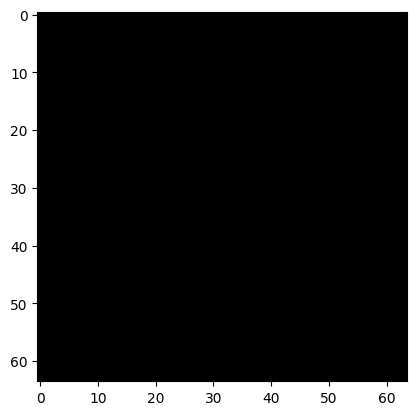

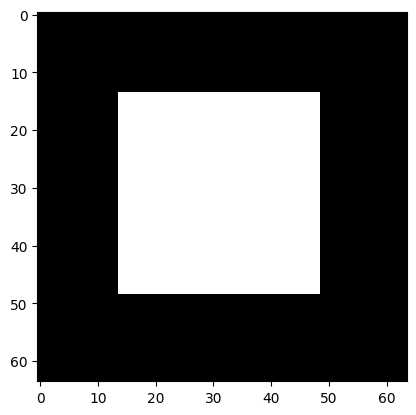

In [6]:
test = binary_generator(2, (img_size, img_size, 1), frac=frac_value)
imgs, y = next(test)

display_img(imgs[0])
display_img(imgs[1])
print("Norm L2 " + str(np.linalg.norm(imgs[1])))
print("Norm L2(count pixels) " + str(math.sqrt(np.size(imgs[1][imgs[1] == 1]))))

#### for ternary generator


Norm L2(imgs[2]-imgs[0]): 35.0
Norm L2(imgs[2]): 35.0
Norm L2(count pixels): 35.0


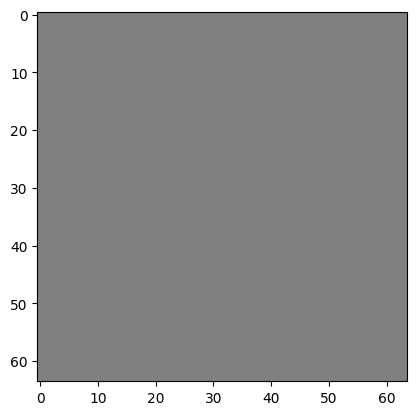

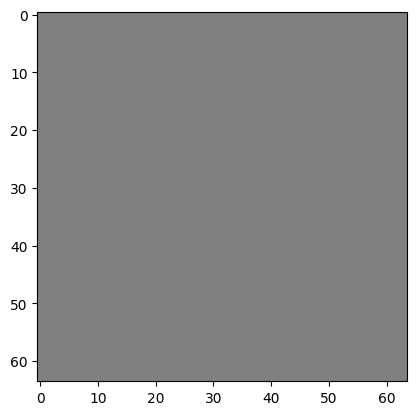

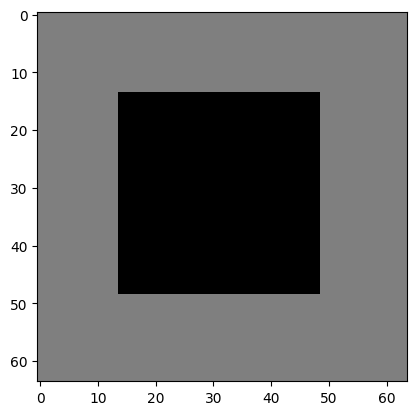

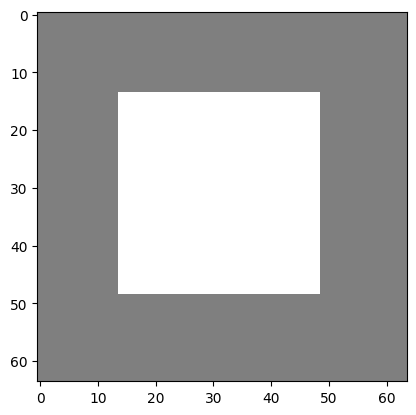

In [7]:
test = ternary_generator(4, (img_size, img_size, 1), frac=frac_value)
imgs, y = next(test)

for i in range(4):
    display_img(
        0.5 * (imgs[i] + 1.0)
    )  # we ensure that there is no negative value wehn displaying images

print("Norm L2(imgs[2]-imgs[0]): " + str(np.linalg.norm(imgs[2] - imgs[0])))
print("Norm L2(imgs[2]): " + str(np.linalg.norm(imgs[2])))
print("Norm L2(count pixels): " + str(math.sqrt(np.size(imgs[2][imgs[2] == -1]))))

### Expe parameters

Now we know the wasserstein distance between the black image and the images with a
square on it. For both binary generator and ternary generator this distance is 35.

We will then compute this distance using a neural network.


In [8]:
batch_size = 64
epochs = 5
steps_per_epoch = 6400

In [9]:
generator = ternary_generator  # binary_generator, ternary_generator
activation = FullSort  # ReLU, MaxMin, GroupSort

### Build lipschitz Model


In [10]:
keras.utils.clear_session()
## please note that the previous helper function has the same behavior as the following code:
inputs = Input((img_size, img_size, 1))
x = Flatten()(inputs)
x = SpectralDense(128, activation=FullSort())(x)
x = SpectralDense(64, activation=FullSort())(x)
x = SpectralDense(32, activation=FullSort())(x)
y = FrobeniusDense(1, activation=None)(x)
wass = Model(inputs=inputs, outputs=y)
wass.summary()

I0000 00:00:1725627748.457893  865036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725627748.481452  865036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725627748.481614  865036 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725627748.482359  865036 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_dense (SpectralDense)  │ (None, 128)            │     1,048,833 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_dense_1                │ (None, 64)             │        16,513 │
│ (SpectralDense)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_dense_2                │ (None, 32)             │         4,161 │
│ (SpectralDense)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ frobenius_dense                 │ (None, 1)              │            65 │
│ (FrobeniusDense)                │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,069,572 (4.08 MB)

 Trainable params: 534,785 (2.04 MB)

 Non-trainable params: 534,787 (2.04 MB)

In [11]:
optimizer = Adam(learning_rate=0.01)

In [12]:
wass.compile(loss=HKR(alpha=0), optimizer=optimizer, metrics=[KR])

### Learn on toy dataset


In [13]:
wass.fit(
    generator(batch_size, (img_size, img_size, 1), frac=frac_value),
    steps_per_epoch=steps_per_epoch // batch_size,
    epochs=epochs,
    verbose=1,
)

Epoch 1/5


I0000 00:00:1725627751.358936  865122 service.cc:146] XLA service 0x55e37b2962f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725627751.358955  865122 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-09-06 15:02:31.406727: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-06 15:02:31.592604: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


 22/100 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - KR: 15.3514 - loss: -15.3514

I0000 00:00:1725627754.350183  865122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - KR: 26.4053 - loss: -26.4053
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - KR: 34.9944 - loss: -34.9944
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - KR: 34.9943 - loss: -34.9943
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - KR: 34.9943 - loss: -34.9943
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - KR: 34.9942 - loss: -34.9942


As we can see the loss converge to the value 35 which is the Wasserstein distance
between the two distributions (square and non-square).
